# Word Counts

Problem: okay counts are wrong

In [1]:
import pandas as pd
import sqlite3
import os
import numpy as np

from helpers.make_latex_table import create_latex_tables
from helpers.normalization import remove_punctuation, remove_punctuation_and_newlines, remove_capitalization
from helpers.statistical_tests import run_t_test_on_gender, compare_genders

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
prompts = pd.read_sql("SELECT ep.*, u.age, u.work_exp_years FROM expanded_prompts ep JOIN users u ON ep.user_id = u.user_id", conn)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Clean, filter and normalize

In [2]:
prompts = prompts[prompts['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]

prompts = prompts.dropna(subset=['conversational'])
prompts = prompts[prompts['conversational'].str.strip() != '']
prompts = prompts.dropna(subset=['conversational'])

#prompts['conversational'] = prompts['conversational'].apply(remove_punctuation_and_newlines)
prompts['conversational'] = prompts['conversational'].apply(remove_capitalization)

## Combine per user

In [3]:
user_prompts = (
    prompts
    .fillna({'work_exp_years': 'None'})
    .groupby(['user_id', 'gender', 'age', 'work_exp_years'])['conversational']
    .apply(' '.join)
    .reset_index()    # Reset index to create a DataFrame
)
user_prompts['n_words'] = user_prompts['conversational'].apply(lambda x: len(x.split()))


## Helper functions and types

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
import seaborn as sns
from helpers.occurences import count_occurrences


def count(df, group_name, word_types, word_lists):
    for word_type, word_list in zip(word_types, word_lists):
        for word in word_list:
            df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
        df[word_type] = df[word_list].sum(axis=1)
    df[group_name] = df[word_types].sum(axis=1)
    return df

gender_palette = {'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'}
age_palette = {'19-25': 'red', '26-30': 'orange', '31-35': 'yellow', '36-40': 'green', '41-50': 'blue', '51-60': 'purple'}


def box_plot(df, id_vars, bar_variables, x_label, y_label, hue_variable, palette):
    melted = df.melt(
    id_vars=id_vars,
    value_vars=bar_variables,
    var_name=x_label,
    value_name=y_label
)

    plt.figure(figsize=(8,6))
    sns.boxplot(
        data=melted,
        x=x_label,
        y=y_label,
        hue=hue_variable,
        palette=palette,
        width=0.7
    )

    plt.title(f'Counts and Scores by {hue_variable}')
    plt.ylabel('Average Count/Score Rate (per word)')
    plt.xlabel('Score/Count')
    plt.legend(title=hue_variable)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def groupwise_comparison_with_correction(df, columns, one_sided=False, direction="greater"):
    stat_vals = []
    dfs= []
    p_vals = []
    test_types = []
    directions = []
    one_sideds = []
    female_means = []
    male_means = []
    female_stds = []
    male_stds = []
    n_females = []
    n_males = []
    nonzero_females = []
    nonzero_males = []
    effsizes = []
    effsize_types = []
    cis = []
    for col in columns:
        result = compare_genders(df, col, one_sided=one_sided, direction=direction)
        stat_vals.append(result['test_statistic'])
        dfs.append(result['df'])
        p_vals.append(result['p_value'])
        test_types.append(result['test_type'])
        directions.append(result['direction'])
        one_sideds.append(result['one_sided'])
        female_means.append(result['m_female'])
        male_means.append(result['m_male'])
        female_stds.append(result['std_female'])
        male_stds.append(result['std_male'])
        n_females.append(result['n_female'])
        n_males.append(result['n_male'])
        nonzero_females.append(result['hits_female'])
        nonzero_males.append(result['hits_male']),
        effsizes.append(result['effect_size']),
        effsize_types.append(result['effect_size_type'])
        cis.append(result['effect_size_CI'])
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'direction': directions,
        'one_sided': one_sideds,
        'df': dfs,
        'stat_value': stat_vals,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'mean_f': female_means,
        'mean_m': male_means,
        'std_f': female_stds,
        'std_m': male_stds,
        'n_f': n_females,
        'n_m': n_males,
        'n_hits_f': nonzero_females,
        'n_hits_m': nonzero_males,
        'effsize': effsizes,
        'effsize_type': effsize_types,
        'ci': cis,
    })
    return results


## Words

In [5]:
import spacy

personal_pronouns = [
    "I", "me", "my", "mine", "myself",
    "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself",
    "she", "her", "hers", "herself",
    "it", "its", "itself",
    "we", "us", "our", "ours", "ourselves",
    "they", "them", "their", "theirs", "themselves"
]

demonstrative_pronouns = [
    "this", "that", "these", "those"
]

interrogative_relative_pronouns = [
    "who", "whom", "whose", "which", "what"
]

pronouns = personal_pronouns + demonstrative_pronouns + interrogative_relative_pronouns

#######################

with open("adjectives_base_cleaned.txt", encoding="utf-8") as f:
    base = [m.strip().lower().rstrip(",") for m in f if m.strip()]

with open("adjectives_comparative.txt", encoding="utf-8") as f:
    comparative = [m.strip().lower().rstrip(",") for m in f if m.strip()]

with open("adjectives_superlative.txt", encoding="utf-8") as f:
    superlative = [m.strip().lower().rstrip(",") for m in f if m.strip()]

#######################

greetings = ['hey', 'hi', 'hello']
thanks_grouped = ['thanks', 'thank you']
please_grouped = ['please', 'pls', 'plz']
yes_no_grouped = ['yes', 'no', 'nah', 'nope']
okay_grouped = ['okay', 'ok']

interactions = greetings + thanks_grouped + please_grouped + yes_no_grouped + okay_grouped

#########################

colloquial = ['ups', 'cool', 'tho', 'nah', 'nope', 'yayyy', 'nice' 'hmmm']
abbreviations = ['pls', 'plz', 'k' 'sry', 'lol', 'wtf']
interjections = ['ah', 'eh']
strong_language = ['shitty', 'bullshit']

informal_language = colloquial + abbreviations + interjections + strong_language


################ Pragmatic Markers

apologies = ['sorry', 'sry', 'ups']
uncertainty_markers = ['maybe', 'type of', 'likely', 'guess', 'not sure', 'think', 'somehow', 'however', 'something', 'quite', 'actually']
uncertainty_expressions = ['if i am not mistaken', 'i think', 'i guess', 'right?']
modal_auxiliary_verbs= ['would', 'can', 'will', 'should', 'could', 'must']

hedges = apologies + uncertainty_markers + modal_auxiliary_verbs + uncertainty_expressions

boosters = ["of course", "completely", "totally", "never", "always", "really", "very", "super"]
# good is never used as booster in the data

# "assurance markers": count the number of prompts that have a booster at the beginning as annotated in categorized prompts ('cool', 'great', 'totally', 'perfect', 'nice')

discourse_markers =  [
    "first", "second", "third", "lastly", "finally", "next", "then", "in the end", "overall", "altogether", "soon", "later", "previously", "now", "currently", "again", "further", "once", "separately",
    "and", "but", "however", "yet", "although", "though", "instead", "or", "otherwise", "also", "besides", "additionally", "moreover", "plus", "thus",
    "therefore", "so", "accordingly", "rather", "still", "for example", "already", "recently", "sometimes", "suddenly", "together",
    "well", "basically", "only", "sadly", "unfortunately", "especially", "normally", "usually", "here"]

# stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = list(nlp.Defaults.stop_words)
print(len(stop_words))
print(stop_words)


326
['does', 'alone', 'their', 'something', 'an', 'for', 'further', 'everything', 'get', 'the', 'whereas', 'six', 'who', 'most', 'sixty', 'your', 'ours', 'seems', 'often', 'some', '‘m', 'had', 'me', 'whose', 'wherever', 'however', 'empty', 'therein', 'otherwise', 'but', 'him', 'whence', 'next', 'becoming', 'move', 'we', 'serious', 'another', 'down', 'whoever', '‘d', 'can', 'two', 'whom', 'call', 'may', 'on', 'up', 'itself', 'you', 'among', 'sometime', 'thereupon', 'wherein', 'are', 'three', 'of', 'within', 'quite', 'nor', 'part', 'five', 'perhaps', 'anyway', 'during', 'before', 'again', 'whole', 'say', 'did', 're', 'upon', 'anyone', "'d", 'beforehand', 'they', 'or', 'else', 'front', 'its', 'various', '‘ll', 'noone', 'hundred', 'along', 'after', 'forty', 'neither', 'be', 'due', 'her', 'make', 'against', 'them', 'same', 'yours', 'ever', 'himself', 'others', 'hereupon', 'enough', 'nothing', '’s', '’d', 'not', 'myself', 'any', '’re', 'only', 'here', "'ll", 'much', 'my', 'seem', 'still', 'b

## Pronouns


In [18]:
pronoun_types = ['personal', 'demonstrative', 'interrog_rel']
pronoun_lists = [personal_pronouns, demonstrative_pronouns, interrogative_relative_pronouns]
pronoun_cols = sum(pronoun_lists, [])


pronoun_counts = count(user_prompts, 'all_pronouns', pronoun_types, pronoun_lists)

zero_cols = pronoun_counts.columns[(pronoun_counts.fillna(0.0) == 0.0).all()].tolist()

pronoun_cols = list(set(pronoun_cols) - set(zero_cols))
personal_pronoun_cols = list(set(personal_pronouns) - set(zero_cols))

#box_plot(pronoun_counts, ['user_id', 'gender'], pronoun_cols, 'Pronoun', 'Normalized Rate (100 Words)', 'gender', gender_palette)
#box_plot(pronoun_counts, ['user_id', 'gender'], pronoun_types, 'Pronoun', 'Normalized Rate (100 Words)', 'gender', gender_palette)
#box_plot(pronoun_counts, ['user_id', 'gender'], personal_pronoun_cols, 'Pronoun', 'Normalized Rate (100 Words)', 'gender', gender_palette)

#box_plot(pronoun_counts, ['age'], pronoun_types, 'Pronoun', 'Normalized Rate (100 Words)', 'age', age_palette)
#box_plot(pronoun_counts, ['age'], 'all_pronouns', 'Pronoun', 'Normalized Rate (100 Words)', 'age', age_palette)



In [19]:
just_personal_pronouns_results = groupwise_comparison_with_correction(pronoun_counts, ['personal'], one_sided=True, direction="smaller")
just_personal_pronouns_results = just_personal_pronouns_results.sort_values(by="p_value", ascending=True)
just_personal_pronouns_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,personal,T-test,smaller,True,25.999188,-1.972181,0.029657,0.029657,0.089525,0.065861,0.02948,0.034012,13,15,13,15,-0.739493,Cohen's d,"[-1.91, 0.08]"


In [20]:
p_word_results = groupwise_comparison_with_correction(pronoun_counts, pronoun_cols)
p_word_results = p_word_results.sort_values(by="p_value", ascending=True)
p_word_results.to_latex("pers_pronouns")
p_word_results


,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
4,me,Mann-Whitney U,greater,False,NaN,41.000000,0.007211,0.165845,0.005155,0.000000,0.009625,0.004170,13.0,15.0,11,5,-0.579487,RBC,"[-0.86, -0.17]"
21,you,Mann-Whitney U,greater,False,NaN,49.500000,0.022660,0.174260,0.011136,0.000000,0.015904,0.006677,13.0,15.0,10,6,-0.492308,RBC,"[-0.8, -0.05]"
5,my,Mann-Whitney U,greater,False,NaN,53.000000,0.024661,0.174260,0.005515,0.000000,0.006672,0.008871,13.0,15.0,9,3,-0.456410,RBC,"[-0.79, -0.1]"
22,they,Mann-Whitney U,greater,False,NaN,59.500000,0.030306,0.174260,0.000000,0.000000,0.001726,0.000413,13.0,15.0,6,2,-0.389744,RBC,"[-0.75, -0.12]"
15,those,Fisher's exact,greater,False,NaN,8.750000,0.055797,0.256667,NaN,NaN,NaN,NaN,NaN,NaN,5,1,8.750000,Odds ratio,None
19,them,Mann-Whitney U,greater,False,NaN,67.500000,0.131991,0.505967,0.001261,0.000000,0.004281,0.007145,13.0,15.0,8,4,-0.307692,RBC,"[-0.66, 0.07]"
20,this,Mann-Whitney U,greater,False,NaN,73.000000,0.266611,0.786325,0.012987,0.006250,0.009057,0.012158,13.0,15.0,11,11,-0.251282,RBC,"[-0.66, 0.16]"
2,these,Mann-Whitney U,greater,False,NaN,80.500000,0.375247,0.786325,0.000000,0.000000,0.003639,0.003139,13.0,15.0,6,4,-0.174359,RBC,"[-0.55, 0.2]"
1,I,T-test,two-sided,False,24.719353,-0.858796,0.398704,0.786325,0.036679,0.032051,0.014733,0.013605,13.0,15.0,13,15,-0.327349,Cohen's d,"[-1.13, 0.42]"
10,us,Fisher's exact,greater,False,NaN,1.777778,0.412077,0.786325,NaN,NaN,NaN,NaN,NaN,NaN,4,3,1.777778,Odds ratio,None


In [21]:
p_group_results = groupwise_comparison_with_correction(pronoun_counts, pronoun_types[1:])
p_group_results = p_group_results.sort_values(by="p_value", ascending=True)
p_group_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
1,interrog_rel,Mann-Whitney U,greater,False,NaN,109.00000,0.597642,0.609284,0.003559,0.003650,0.004365,0.010083,13,15,7,9,0.117949,RBC,"[-0.34, 0.52]"
0,demonstrative,T-test,two-sided,False,25.328778,-0.51752,0.609284,0.609284,0.028494,0.025367,0.016049,0.015826,13,15,12,14,-0.196310,Cohen's d,"[-1.03, 0.53]"


In [11]:
overall_results = groupwise_comparison_with_correction(pronoun_counts, ['all_pronouns'])
overall_results = overall_results.sort_values(by="p_value", ascending=True)
overall_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,CI
0,all_pronouns,Mann-Whitney U,greater,False,None,64.0,0.128419,0.128419,0.130515,0.086735,0.038311,0.035527,13,15,13,15,-0.34359,RBC,"[-0.85, 0.08]"


## to latex

In [14]:
combined_pronouns = pd.concat([just_personal_pronouns_results, p_group_results, p_word_results], axis=0)

create_latex_tables(combined_pronouns, "combined_pronouns_stats", "combined_pronouns_eff")
combined_pronouns


KeyError: 'ci'

In [13]:
pronoun_types = ['personal', 'demonstrative', 'interrogative_relative']
melted = pronoun_counts.melt(
    id_vars=['user_id', 'gender'],
    value_vars=pronoun_types,
    var_name='pronoun_type',
    value_name='pronoun_rate'
)

model = ols('pronoun_rate ~ gender * pronoun_type', data=melted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)


                       sum_sq    df          F        PR(>F)
gender               0.001252   1.0   2.801140  9.820326e-02
pronoun_type         0.074364   2.0  83.163738  4.578987e-20
gender:pronoun_type  0.002804   2.0   3.135833  4.899005e-02
Residual             0.034873  78.0        NaN           NaN


## Adjectives

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_32698/1702864359.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_32698/1702864359.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_32698/1702864359.py

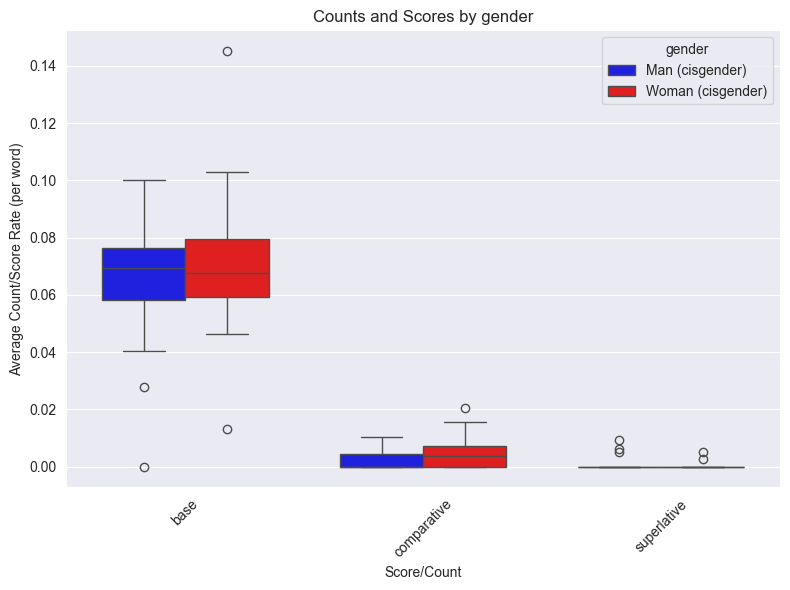

In [6]:
adj_types = ['base', 'comparative', 'superlative']
adj_lists = [base, comparative, superlative]
adj_cols = sum(adj_lists, [])

adj_counts = count(user_prompts, 'all_adjs', adj_types, adj_lists)

zero_cols = adj_counts.columns[(adj_counts.fillna(0.0) == 0.0).all()].tolist()
adj_cols = list(set(adj_cols) - set(zero_cols))
#box_plot(adj_counts, ['user_id', 'gender'], adj_cols, 'Adjective', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(adj_counts, ['user_id', 'gender'], adj_types, 'Adjective', 'Normalized Rate (100 Words)', 'gender', gender_palette)

#box_plot(adj_counts, ['age'], adj_types, 'Adjective', 'Normalized Rate (100 Words)', 'age', age_palette)
#box_plot(adj_counts, ['age'], 'all_adjs', 'Adjective', 'Normalized Rate (100 Words)', 'age', age_palette)

In [7]:
adj_word_results = groupwise_comparison_with_correction(adj_counts, adj_cols)
adj_word_results = adj_word_results.sort_values(by="p_value", ascending=True)
adj_word_results

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
218,more,Mann-Whitney U,greater,False,None,49.0,0.012109,0.531453,0.003462,0.000480,0.004245,0.001159,13,15,8,3,-0.497436,RBC
121,new,Mann-Whitney U,greater,False,None,51.0,0.025539,0.531453,0.006788,0.001653,0.010244,0.003255,13,15,10,5,-0.476923,RBC
72,same,Mann-Whitney U,greater,False,None,55.0,0.035505,0.531453,0.005241,0.001257,0.008847,0.002934,13,15,9,4,-0.435897,RBC
234,balanced,Mann-Whitney U,greater,False,None,75.0,0.059167,0.531453,0.004110,0.000000,0.013347,0.000000,13,15,3,0,-0.230769,RBC
120,standard,Mann-Whitney U,greater,False,None,75.0,0.059167,0.531453,0.001061,0.000000,0.002860,0.000000,13,15,3,0,-0.230769,RBC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,average,Mann-Whitney U,greater,False,None,97.0,1.000000,1.000000,0.000024,0.000153,0.000087,0.000592,13,15,1,1,-0.005128,RBC
207,able,Mann-Whitney U,greater,False,None,97.0,1.000000,1.000000,0.000024,0.000049,0.000087,0.000188,13,15,1,1,-0.005128,RBC
110,old,Mann-Whitney U,greater,False,None,97.0,1.000000,1.000000,0.000024,0.000074,0.000087,0.000285,13,15,1,1,-0.005128,RBC
186,raw,Mann-Whitney U,greater,False,None,97.0,1.000000,1.000000,0.000509,0.000725,0.001837,0.002807,13,15,1,1,-0.005128,RBC


In [8]:
adj_group_results = groupwise_comparison_with_correction(adj_counts, adj_types)
adj_group_results = adj_group_results.sort_values(by="p_value", ascending=True)
adj_group_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
1,comparative,Mann-Whitney U,greater,False,NaN,67.000000,0.133142,0.399426,0.005800,0.002243,0.006697,0.003553,13,15,8,5,-0.312821,RBC
0,base,T-test,two-sided,False,23.258648,-0.666278,0.511788,0.629241,0.070620,0.063493,0.030680,0.025110,13,15,13,14,-0.256206,Cohen's d
2,superlative,Mann-Whitney U,greater,False,NaN,105.000000,0.629241,0.629241,0.000584,0.001374,0.001518,0.002958,13,15,2,3,0.076923,RBC


In [9]:
adj_all_results = groupwise_comparison_with_correction(adj_counts, ['all_adjs'])
adj_all_results = adj_all_results.sort_values(by="p_value", ascending=True)
adj_all_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,all_adjs,T-test,two-sided,False,24.724913,-0.943577,0.354515,0.354515,0.077004,0.067109,0.028663,0.026483,13,15,13,14,-0.359651,Cohen's d


In [10]:
adj_combined = pd.concat([adj_all_results, adj_group_results], axis=0)
create_latex_table_from_stats(adj_combined, "combined_adjs")
adj_combined

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,all_adjs,T-test,two-sided,False,24.724913,-0.943577,0.354515,0.354515,0.077004,0.067109,0.028663,0.026483,13,15,13,14,-0.359651,Cohen's d
1,comparative,Mann-Whitney U,greater,False,NaN,67.000000,0.133142,0.399426,0.005800,0.002243,0.006697,0.003553,13,15,8,5,-0.312821,RBC
0,base,T-test,two-sided,False,23.258648,-0.666278,0.511788,0.629241,0.070620,0.063493,0.030680,0.025110,13,15,13,14,-0.256206,Cohen's d
2,superlative,Mann-Whitney U,greater,False,NaN,105.000000,0.629241,0.629241,0.000584,0.001374,0.001518,0.002958,13,15,2,3,0.076923,RBC


## Pragmatic Markers


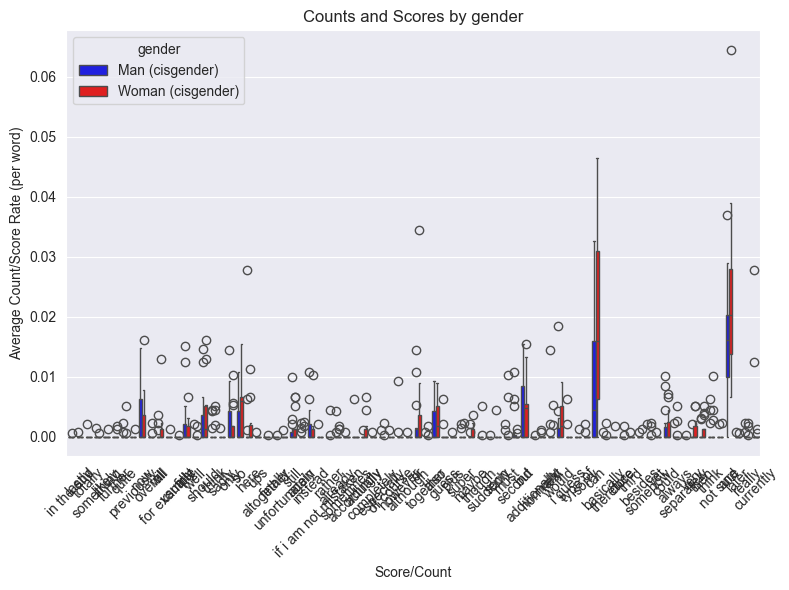

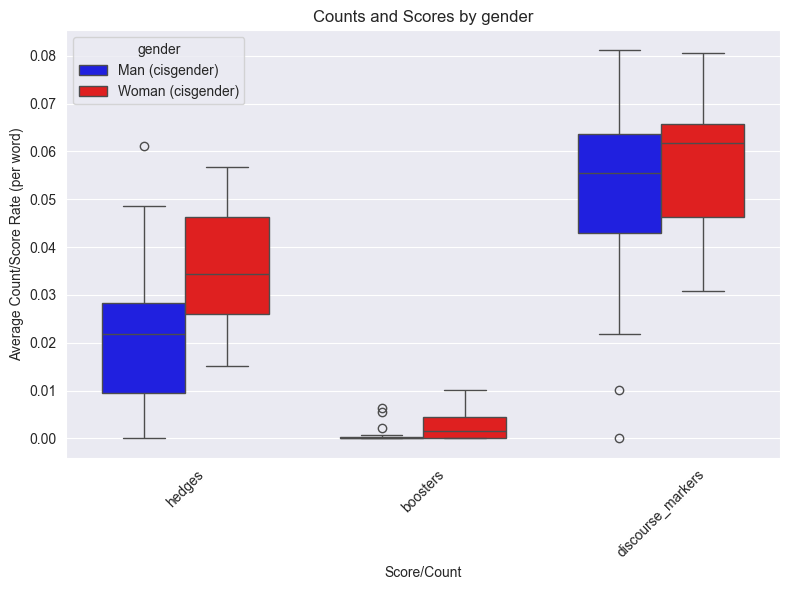

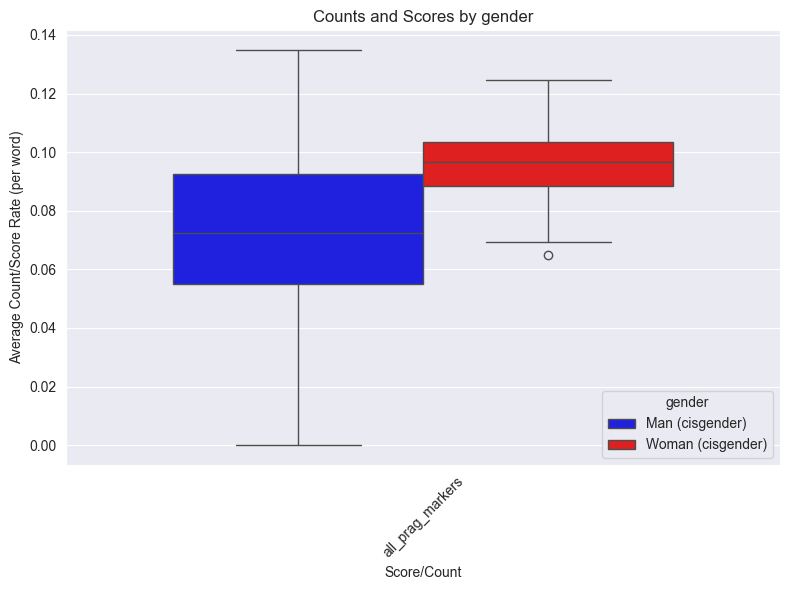

In [7]:
prag_marker_types = ['hedges', 'boosters', 'discourse_markers']
prag_marker_lists = [hedges, boosters, discourse_markers]
prag_marker_cols = sum(prag_marker_lists, [])

prag_marker_types_no_hedges = ['boosters', 'discourse_markers']
prag_marker_lists_no_hedges = [boosters, discourse_markers]
prag_marker_cols_no_hedges = sum(prag_marker_lists_no_hedges, [])

hedges_types = ['apologies', 'uncertainty_markers', 'uncertainty_expressions', 'modal_auxiliary_verbs']

prag_marker_counts = count(user_prompts, 'all_prag_markers', prag_marker_types, prag_marker_lists)
#hedges_counts = count(user_prompts, 'all_hedges', hedges_types, [hedges])

zero_cols = prag_marker_counts.columns[(prag_marker_counts.fillna(0.0) == 0.0).all()].tolist()
prag_marker_cols = list(set(prag_marker_cols) - set(zero_cols))
box_plot(prag_marker_counts, ['user_id', 'gender'], prag_marker_cols, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(prag_marker_counts, ['user_id', 'gender'], prag_marker_types, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(prag_marker_counts, ['user_id', 'gender'], ['all_prag_markers'], 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)


In [8]:
prag_word_results = groupwise_comparison_with_correction(prag_marker_counts, prag_marker_cols)
prag_word_results = prag_word_results.sort_values(by="p_value", ascending=True)
#create_latex_table_from_stats(prag_word_results, "prag_word_results")
prag_word_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
70,very,Fisher's exact,greater,False,None,8.750000,0.055797,0.950614,NaN,NaN,NaN,NaN,NaN,NaN,5,1,8.750000,Odds ratio,None
59,can,Mann-Whitney U,greater,False,None,56.000000,0.056034,0.950614,0.016014,0.004505,0.014670,0.010735,13.0,15.0,11,9,-0.425641,RBC,"[-0.79, -0.04]"
33,actually,Fisher's exact,greater,False,None,6.222222,0.122222,0.950614,NaN,NaN,NaN,NaN,NaN,NaN,4,1,6.222222,Odds ratio,None
71,then,Fisher's exact,greater,False,None,4.062500,0.137319,0.950614,NaN,NaN,NaN,NaN,NaN,NaN,5,2,4.062500,Odds ratio,None
74,and,Mann-Whitney U,greater,False,None,65.000000,0.140403,0.950614,0.020305,0.016043,0.015239,0.010196,13.0,15.0,13,13,-0.333333,RBC,"[-0.71, 0.05]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,completely,Fisher's exact,greater,False,None,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0.000000,Odds ratio,None
36,of course,Fisher's exact,greater,False,None,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0.000000,Odds ratio,None
37,however,Fisher's exact,greater,False,None,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0.000000,Odds ratio,None
63,third,Fisher's exact,greater,False,None,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0.000000,Odds ratio,None


In [9]:
prag_hedges_group_results = groupwise_comparison_with_correction(prag_marker_counts, hedges_types)
prag_hedges_group_results = prag_hedges_group_results.sort_values(by="p_value", ascending=True)
#create_latex_table_from_stats(prag_hedges_group_results, "hedges_group_results")
prag_hedges_group_results

KeyError: 'uncertainty_markers'

In [22]:
prag_group_results = groupwise_comparison_with_correction(prag_marker_counts, prag_marker_types_no_hedges)
prag_group_results = prag_group_results.sort_values(by="p_value", ascending=True)
prag_group_results

NameError: name 'prag_marker_counts' is not defined

In [37]:
prag_overall_results = groupwise_comparison_with_correction(prag_marker_counts, ['all_prag_markers'])
prag_overall_results = prag_overall_results.sort_values(by="p_value", ascending=True)
prag_overall_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,all_prag_markers,T-test,two-sided,False,21.568177,-2.117358,0.046006,0.046006,0.095374,0.072922,0.018556,0.035907,13,15,13,14,-0.768669,Cohen's d


In [38]:
only_hedges = groupwise_comparison_with_correction(hedges_counts, ['hedges'], one_sided=True, direction="smaller")
only_hedges = only_hedges.sort_values(by="p_value", ascending=True)
only_hedges

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,hedges,T-test,smaller,True,25.856005,-2.368255,0.012817,0.012817,0.035585,0.021427,0.01404,0.017566,13,15,13,12,-0.882866,Cohen's d


In [39]:
prag_combined = pd.concat([prag_overall_results, only_hedges, prag_group_results], axis=0)
create_latex_table_from_stats(prag_combined, "combined_prag_markers")
prag_combined

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,all_prag_markers,T-test,two-sided,False,21.568177,-2.117358,0.046006,0.046006,0.095374,0.072922,0.018556,0.035907,13,15,13,14,-0.768669,Cohen's d
0,hedges,T-test,smaller,True,25.856005,-2.368255,0.012817,0.012817,0.035585,0.021427,0.014040,0.017566,13,15,13,12,-0.882866,Cohen's d
0,boosters,Mann-Whitney U,greater,False,NaN,72.000000,0.191298,0.355488,0.002328,0.000987,0.003113,0.002093,13,15,7,4,-0.261538,RBC
1,discourse_markers,T-test,two-sided,False,23.595982,-0.942499,0.355488,0.355488,0.057461,0.050508,0.014629,0.023866,13,15,13,14,-0.345332,Cohen's d


## Interactions


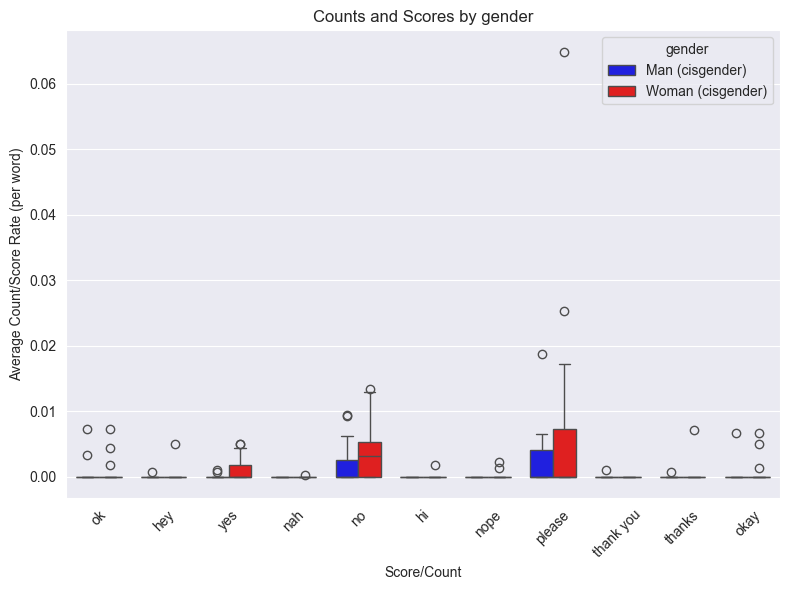

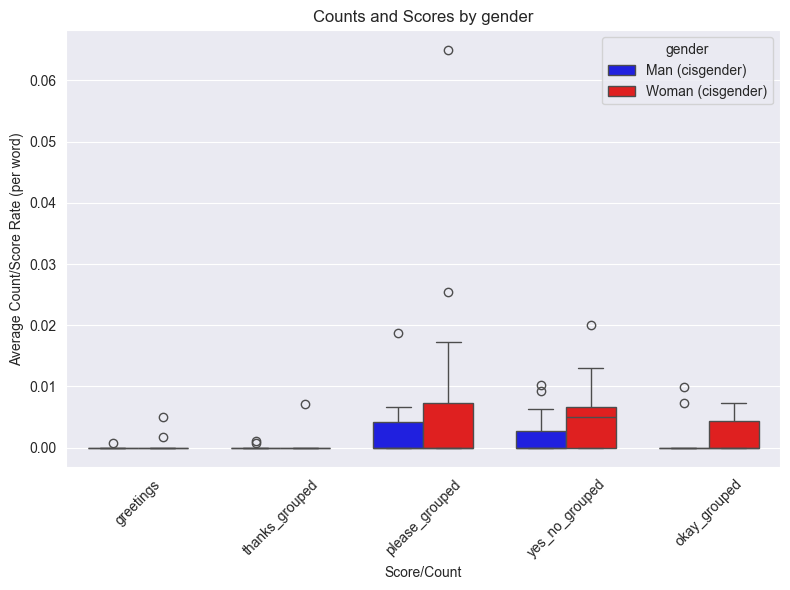

,user_id,gender,age,work_exp_years,conversational,n_words,I,me,my,mine,...,lol,wtf,abbreviations,ah,eh,interjections,shitty,bullshit,strong_language,all_inf_markers
0,6,Man (cisgender),19-25,3.0,"parsing data from python iterator, how it coul...",196,0.015306,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,8,Man (cisgender),19-25,1.0,\n i am working on the problem of reconstru...,36,0.027778,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,11,Woman (cisgender),26-30,1.0,can you adapt the following code so that inste...,194,0.030928,0.005155,0.015464,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,15,Man (cisgender),26-30,6.0,set_all_tables action is currently not fetchin...,36,0.055556,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,16,Woman (cisgender),19-25,None,i want to use dummy hot encoding to replace th...,544,0.051471,0.001838,0.005515,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,25,Man (cisgender),26-30,6.0,what is the best way to encode and compress a ...,108,0.027778,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,28,Woman (cisgender),31-35,5.0,i have a pandas dataframe like this:\n\ni want...,562,0.039146,0.010676,0.005338,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,29,Woman (cisgender),26-30,None,now i want to bring judgement balancing into t...,62,0.032258,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,31,Man (cisgender),36-40,22.0,how can i make use of an observablehqdatabasec...,92,0.032609,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,34,Man (cisgender),51-60,20.0,blender and python. i have a collection of hun...,1309,0.019862,0.000000,0.001528,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000764


In [55]:
int_marker_types = ['greetings', 'thanks_grouped', 'please_grouped', 'yes_no_grouped', 'okay_grouped']
int_marker_lists = [greetings, thanks_grouped, please_grouped, yes_no_grouped, okay_grouped]
int_marker_cols = sum(int_marker_lists, [])

int_marker_counts = count(user_prompts, 'all_int_markers', int_marker_types, int_marker_lists)

zero_cols = int_marker_counts.columns[(int_marker_counts.fillna(0.0) == 0.0).all()].tolist()
int_marker_cols = list(set(int_marker_cols) - set(zero_cols))
box_plot(int_marker_counts, ['user_id', 'gender'], int_marker_cols, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(int_marker_counts, ['user_id', 'gender'], int_marker_types, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)

int_marker_counts

In [56]:
int_word_results = groupwise_comparison_with_correction(int_marker_counts, int_marker_cols)
int_word_results = int_word_results.sort_values(by="p_value", ascending=True)
int_word_results

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
2,yes,Mann-Whitney U,greater,False,None,70.0,0.102008,0.503873,0.001287,0.000122,0.002102,0.000331,13,15,5,2,-0.282051,RBC
6,nope,Mann-Whitney U,greater,False,None,82.5,0.134805,0.503873,0.000274,0.000000,0.000693,0.000000,13,15,2,0,-0.153846,RBC
10,okay,Mann-Whitney U,greater,False,None,82.0,0.256326,0.503873,0.001007,0.000442,0.002217,0.001712,13,15,3,1,-0.158974,RBC
3,nah,Mann-Whitney U,greater,False,None,90.0,0.316073,0.503873,0.000024,0.000000,0.000087,0.000000,13,15,1,0,-0.076923,RBC
5,hi,Mann-Whitney U,greater,False,None,90.0,0.316073,0.503873,0.000137,0.000000,0.000494,0.000000,13,15,1,0,-0.076923,RBC
4,no,Mann-Whitney U,greater,False,None,77.0,0.316722,0.503873,0.003856,0.002085,0.004777,0.003430,13,15,7,6,-0.210256,RBC
7,please,Mann-Whitney U,greater,False,None,78.0,0.320647,0.503873,0.009559,0.002659,0.018440,0.005091,13,15,6,5,-0.200000,RBC
8,thank you,Mann-Whitney U,greater,False,None,104.0,0.390154,0.536462,0.000000,0.000074,0.000000,0.000285,13,15,0,1,0.066667,RBC
0,ok,Mann-Whitney U,greater,False,None,88.0,0.534773,0.653611,0.001040,0.000708,0.002281,0.002013,13,15,3,2,-0.097436,RBC
1,hey,Mann-Whitney U,greater,False,None,96.0,0.917858,0.917858,0.000390,0.000049,0.001408,0.000188,13,15,1,1,-0.015385,RBC


In [57]:
int_group_results = groupwise_comparison_with_correction(int_marker_counts, int_marker_types)
int_group_results = int_group_results.sort_values(by="p_value", ascending=True)
create_latex_table_from_stats(int_group_results, "int_group_results")
int_group_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
4,okay_grouped,Mann-Whitney U,greater,False,None,70.5,0.125847,0.333008,0.002047,0.001150,0.002802,0.003075,13,15,6,2,-0.276923,RBC
3,yes_no_grouped,Mann-Whitney U,greater,False,None,66.5,0.133203,0.333008,0.005440,0.002207,0.006175,0.003534,13,15,8,6,-0.317949,RBC
2,please_grouped,Mann-Whitney U,greater,False,None,78.0,0.320647,0.534411,0.009559,0.002659,0.018440,0.005091,13,15,6,5,-0.200000,RBC
0,greetings,Mann-Whitney U,greater,False,None,88.0,0.440153,0.550191,0.000527,0.000049,0.001453,0.000188,13,15,2,1,-0.097436,RBC
1,thanks_grouped,Mann-Whitney U,greater,False,None,102.0,0.731537,0.731537,0.000547,0.000122,0.001974,0.000331,13,15,1,2,0.046154,RBC


In [58]:
int_overall_results = groupwise_comparison_with_correction(int_marker_counts, ['all_int_markers'])
int_overall_results = int_overall_results.sort_values(by="p_value", ascending=True)
int_overall_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,all_int_markers,Mann-Whitney U,greater,False,None,65.5,0.120944,0.120944,0.018121,0.006187,0.022495,0.009336,13,15,8,6,-0.328205,RBC


In [59]:
int_combined = pd.concat([int_overall_results, int_group_results], axis=0)
create_latex_table_from_stats(int_combined, "combined_int_markers")
int_combined

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,all_int_markers,Mann-Whitney U,greater,False,None,65.5,0.120944,0.120944,0.018121,0.006187,0.022495,0.009336,13,15,8,6,-0.328205,RBC
4,okay_grouped,Mann-Whitney U,greater,False,None,70.5,0.125847,0.333008,0.002047,0.001150,0.002802,0.003075,13,15,6,2,-0.276923,RBC
3,yes_no_grouped,Mann-Whitney U,greater,False,None,66.5,0.133203,0.333008,0.005440,0.002207,0.006175,0.003534,13,15,8,6,-0.317949,RBC
2,please_grouped,Mann-Whitney U,greater,False,None,78.0,0.320647,0.534411,0.009559,0.002659,0.018440,0.005091,13,15,6,5,-0.200000,RBC
0,greetings,Mann-Whitney U,greater,False,None,88.0,0.440153,0.550191,0.000527,0.000049,0.001453,0.000188,13,15,2,1,-0.097436,RBC
1,thanks_grouped,Mann-Whitney U,greater,False,None,102.0,0.731537,0.731537,0.000547,0.000122,0.001974,0.000331,13,15,1,2,0.046154,RBC


## Informal

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_32907/1702864359.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_32907/1702864359.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_32907/1702864359.py

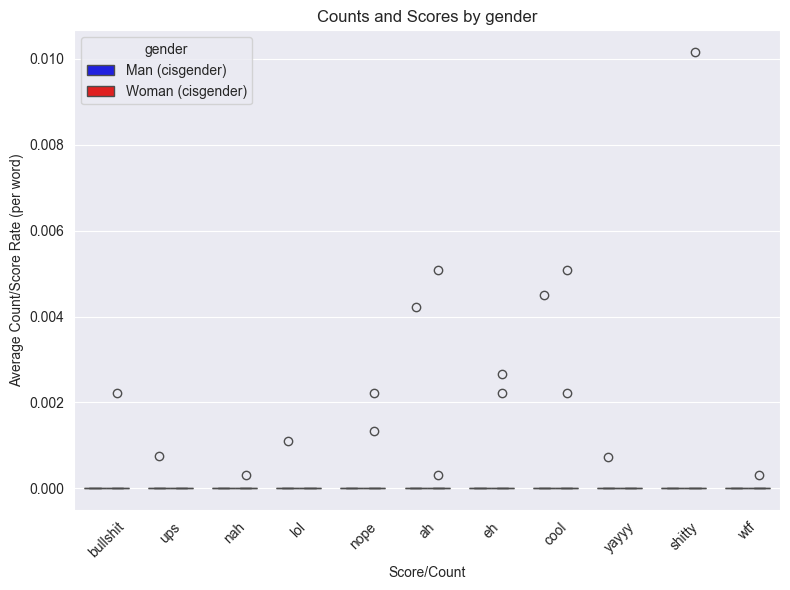

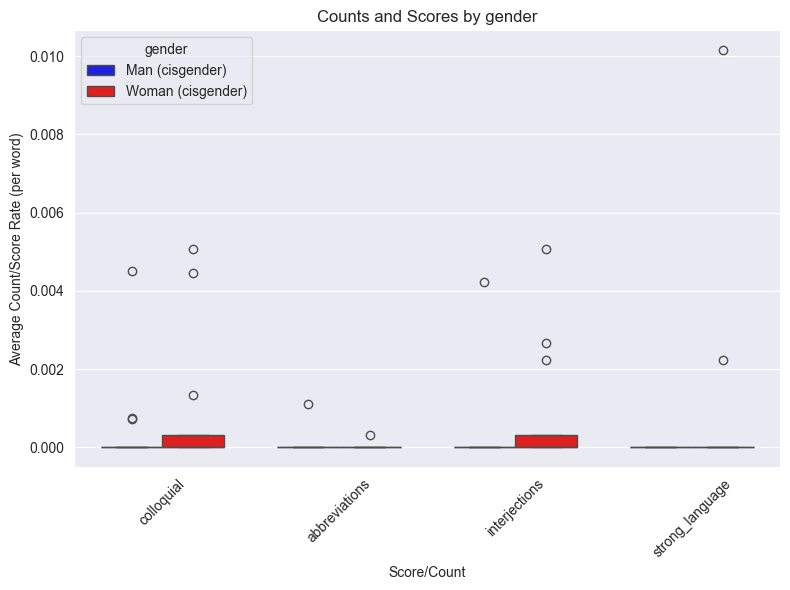

In [46]:
inf_marker_types = ['colloquial', 'abbreviations', 'interjections', 'strong_language']
inf_marker_lists = [colloquial, abbreviations, interjections, strong_language]
inf_marker_cols = sum(inf_marker_lists, [])

inf_marker_counts = count(user_prompts, 'all_inf_markers', inf_marker_types, inf_marker_lists)

zero_cols = inf_marker_counts.columns[(inf_marker_counts.fillna(0.0) == 0.0).all()].tolist()
inf_marker_cols = list(set(inf_marker_cols) - set(zero_cols))
box_plot(inf_marker_counts, ['user_id', 'gender'], inf_marker_cols, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(inf_marker_counts, ['user_id', 'gender'], inf_marker_types, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)

In [50]:
inf_word_results = groupwise_comparison_with_correction(inf_marker_counts, inf_marker_cols)
inf_word_results = inf_word_results.sort_values(by="p_value", ascending=True)
inf_word_results

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
4,nope,Mann-Whitney U,greater,False,None,82.5,0.134805,0.476855,0.000274,0.000000,0.000693,0.000000,13,15,2,0,-0.153846,RBC
6,eh,Mann-Whitney U,greater,False,None,82.5,0.134805,0.476855,0.000376,0.000000,0.000922,0.000000,13,15,2,0,-0.153846,RBC
0,bullshit,Mann-Whitney U,greater,False,None,90.0,0.316073,0.476855,0.000171,0.000000,0.000618,0.000000,13,15,1,0,-0.076923,RBC
2,nah,Mann-Whitney U,greater,False,None,90.0,0.316073,0.476855,0.000024,0.000000,0.000087,0.000000,13,15,1,0,-0.076923,RBC
9,shitty,Mann-Whitney U,greater,False,None,90.0,0.316073,0.476855,0.000781,0.000000,0.002816,0.000000,13,15,1,0,-0.076923,RBC
10,wtf,Mann-Whitney U,greater,False,None,90.0,0.316073,0.476855,0.000024,0.000000,0.000087,0.000000,13,15,1,0,-0.076923,RBC
1,ups,Mann-Whitney U,greater,False,None,104.0,0.390154,0.476855,0.000000,0.000051,0.000000,0.000197,13,15,0,1,0.066667,RBC
3,lol,Mann-Whitney U,greater,False,None,104.0,0.390154,0.476855,0.000000,0.000074,0.000000,0.000285,13,15,0,1,0.066667,RBC
8,yayyy,Mann-Whitney U,greater,False,None,104.0,0.390154,0.476855,0.000000,0.000049,0.000000,0.000188,13,15,0,1,0.066667,RBC
5,ah,Mann-Whitney U,greater,False,None,89.0,0.492609,0.492609,0.000415,0.000281,0.001403,0.001089,13,15,2,1,-0.087179,RBC


In [51]:
inf_group_results  = groupwise_comparison_with_correction(inf_marker_counts, inf_marker_types)
inf_group_results  = inf_group_results .sort_values(by="p_value", ascending=True)
inf_group_results

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
2,interjections,Mann-Whitney U,greater,False,None,75.0,0.129177,0.269610,0.000791,0.000281,0.001575,0.001089,13,15,4,1,-0.230769,RBC
3,strong_language,Mann-Whitney U,greater,False,None,82.5,0.134805,0.269610,0.000952,0.000000,0.002832,0.000000,13,15,2,0,-0.153846,RBC
0,colloquial,Mann-Whitney U,greater,False,None,86.0,0.505289,0.673719,0.000860,0.000400,0.001776,0.001165,13,15,4,3,-0.117949,RBC
1,abbreviations,Mann-Whitney U,greater,False,None,97.0,1.000000,1.000000,0.000024,0.000074,0.000087,0.000285,13,15,1,1,-0.005128,RBC


In [52]:
inf_overall_result = groupwise_comparison_with_correction(inf_marker_counts, ['all_inf_markers'])
inf_overall_result = inf_overall_result.sort_values(by="p_value", ascending=True)
inf_overall_result

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,all_inf_markers,Mann-Whitney U,greater,False,None,95.0,0.911559,0.911559,0.002626,0.000755,0.005907,0.001509,13,15,4,5,-0.025641,RBC


In [53]:
inf_combined = pd.concat([inf_overall_result, inf_group_results], axis=0)
create_latex_table_from_stats(inf_combined, "combined_inf_markers")
inf_combined

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,all_inf_markers,Mann-Whitney U,greater,False,None,95.0,0.911559,0.911559,0.002626,0.000755,0.005907,0.001509,13,15,4,5,-0.025641,RBC
2,interjections,Mann-Whitney U,greater,False,None,75.0,0.129177,0.269610,0.000791,0.000281,0.001575,0.001089,13,15,4,1,-0.230769,RBC
3,strong_language,Mann-Whitney U,greater,False,None,82.5,0.134805,0.269610,0.000952,0.000000,0.002832,0.000000,13,15,2,0,-0.153846,RBC
0,colloquial,Mann-Whitney U,greater,False,None,86.0,0.505289,0.673719,0.000860,0.000400,0.001776,0.001165,13,15,4,3,-0.117949,RBC
1,abbreviations,Mann-Whitney U,greater,False,None,97.0,1.000000,1.000000,0.000024,0.000074,0.000087,0.000285,13,15,1,1,-0.005128,RBC
